<a href="https://colab.research.google.com/github/bksat90/FinalProject/blob/main/classification_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# necessary imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import pathlib
import PIL
import tensorflow as tf

from PIL import Image, ImageFilter
from tensorflow import keras
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
# mounting gdrive.
from google.colab import drive

drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Unzip the images. (one time activity)
!unzip "/content/drive/MyDrive/Project_BC/archive.zip" -d "/content/drive/MyDrive/Project_BC/cnn/"

Archive:  /content/drive/MyDrive/Project_BC/archive.zip
replace /content/drive/MyDrive/Project_BC/cnn/test/0/105_1934323665_png.rf.a1e70bb0747c86f17a76a13894e8e191.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

# **Exploratory Data Analysis**

In [3]:
# find the data counts for training data
path = "/content/drive/MyDrive/Project_BC/cnn/train/"
tr_benign = len(os.listdir(path + "/0"))
tr_malignant = len(os.listdir(path + "/1"))
print('Number of benign images:' , tr_benign)
print('Number of malignant images:' , tr_malignant)

Number of benign images: 687
Number of malignant images: 280


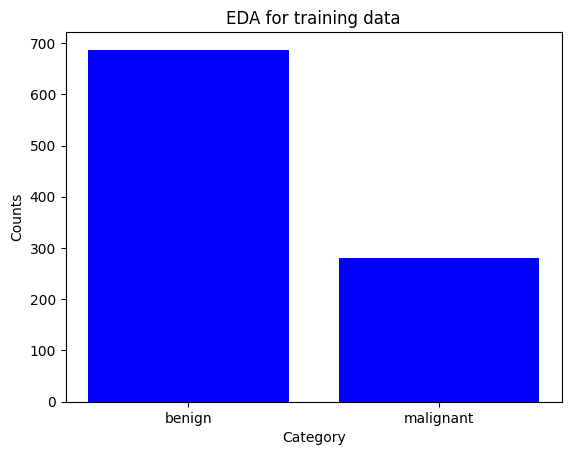

In [4]:
# depict the data into graph for training data
labels = ['benign', 'malignant']
counts = [tr_benign, tr_malignant]

plt.bar(labels, counts, color ='blue')
plt.xlabel('Category')
plt.ylabel('Counts')
plt.title('EDA for training data')
plt.show()

In [5]:
# find the data counts for test data
path = "/content/drive/MyDrive/Project_BC/cnn/test/"
tt_benign = len(os.listdir(path + "/0"))
tt_malignant = len(os.listdir(path + "/1"))
print('Number of benign images:', tt_benign)
print('Number of malignant images:', tt_malignant)

Number of benign images: 118
Number of malignant images: 85


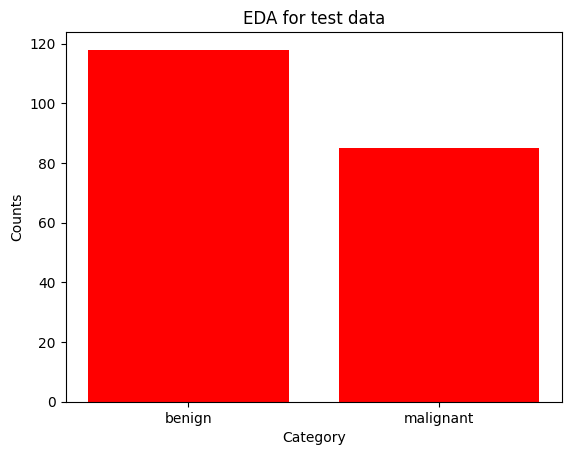

In [6]:
# depict the data into graph for test data
test_labels = ['benign', 'malignant']
test_counts = [tt_benign, tt_malignant]

plt.bar(test_labels, test_counts, color ='red')
plt.xlabel('Category')
plt.ylabel('Counts')
plt.title('EDA for test data')
plt.show()

# **Data Preprocessing**

In [ ]:
# define median filter function
def median_filter(sourcepath, targetpath):
  for filename in os.listdir(sourcepath):
    pic = Image.open(sourcepath + filename)
    pic = pic.filter(ImageFilter.MedianFilter(size=3))
    pic.save(targetpath + filename)

In [ ]:
def call_filter(srcpath, trgpath):
  # apply the filter for the benign images
  sourcepath = srcpath + "0/"
  targetpath = trgpath + "0/"
  median_filter(sourcepath, targetpath)

  # apply the filter for the malignant images
  sourcepath = srcpath + "1/"
  targetpath = trgpath + "1/"
  median_filter(sourcepath, targetpath)

In [ ]:
# apply the filter for the training images
srcpath = "/content/drive/MyDrive/Project_BC/cnn/train/"
trgpath = "/content/drive/MyDrive/Project_BC/median/train/"
call_filter(srcpath, trgpath)

In [ ]:
# apply the filter for the test images
srcpath = "/content/drive/MyDrive/Project_BC/cnn/test/"
trgpath = "/content/drive/MyDrive/Project_BC/median/test/"
call_filter(srcpath, trgpath)

In [ ]:
# copy the image
def copy(sourcepath, targetpath):
  for filename in os.listdir(sourcepath):
    pic = Image.open(sourcepath + filename)
    pic.save(targetpath + filename)

In [ ]:
# apply vertical flip
def flip_vertical(sourcepath, targetpath):
  for filename in os.listdir(sourcepath):
    pic = Image.open(sourcepath + filename)
    pic = pic.transpose(Image.FLIP_TOP_BOTTOM)
    pic.save(targetpath + 'vert' + filename)

In [ ]:
# apply horizontal flip
def flip_horizontal(sourcepath, targetpath):
  for filename in os.listdir(sourcepath):
    pic = Image.open(sourcepath + filename)
    pic = pic.transpose(Image.FLIP_LEFT_RIGHT)
    pic.save(targetpath + 'horiz' + filename)

In [ ]:
def call_flip(srcpath, trgpath):
  # apply the flip for the benign images
  sourcepath = srcpath + "0/"
  targetpath = trgpath + "0/"
  copy(sourcepath, targetpath)
  flip_vertical(sourcepath, targetpath)
  flip_horizontal(sourcepath, targetpath)

  # apply the flip for the malignant images
  sourcepath = srcpath + "1/"
  targetpath = trgpath + "1/"
  copy(sourcepath, targetpath)
  flip_vertical(sourcepath, targetpath)
  flip_horizontal(sourcepath, targetpath)

In [ ]:
# apply the flips for the training images
srcpath = "/content/drive/MyDrive/Project_BC/median/train/"
trgpath = "/content/drive/MyDrive/Project_BC/flip/train/"
call_flip(srcpath, trgpath)

In [ ]:
# apply the flips for the test images
srcpath = "/content/drive/MyDrive/Project_BC/median/test/"
trgpath = "/content/drive/MyDrive/Project_BC/flip/test/"
call_flip(srcpath, trgpath)

# **Model**

In [3]:
label_dict = {'benign' : 0, 'malignant' : 1}

def process_image(filename):
  pieces = tf.strings.split(filename, '/')
  label = pieces[-2]
  label = tf.strings.to_number(label)
  picture = tf.io.read_file(filename)
  picture = tf.io.decode_jpeg(picture)
  return picture, label

In [4]:
# resize the images
def resize(picture, label):
    picture = tf.image.resize(tf.cast(picture, tf.float32),
                            size=[128,128])/255.0
    return picture, label

In [5]:
# prepare the dataset list of the input files
loc = "/content/drive/MyDrive/Project_BC/flip/"

train_data = tf.data.Dataset.list_files(loc + "train/*/*")
test_data = tf.data.Dataset.list_files(loc + "test/*/*")

In [6]:
# processing the training data
train_data = train_data.shuffle(1000)
train_data = train_data.map(process_image)
train_data = train_data.map(resize)
train_data = train_data.batch(32)

# processing the test data
test_data = test_data.shuffle(1000)
test_data = test_data.map(process_image)
test_data = test_data.map(resize)
test_data = test_data.batch(32)

Model 1:

In [7]:
# three convolution layer model

input_layer = layers.Input(shape=(128, 128, 3), name='Input')

conv0 = layers.Conv2D(16, (5, 5), activation='relu', padding="same",
                      strides=(2, 2), name='Conv0')(input_layer)
conv1 = layers.Conv2D(32, (3, 3), activation='relu', padding="same",
                      strides=(1, 1), name='Conv1')(conv0)
conv2 = layers.Conv2D(32, (3, 3), activation='relu', padding="same",
                      strides=(1, 1), name='Conv2')(conv1)
pool1 = layers.MaxPooling2D((2, 2), name='Pool1')(conv2)

batch1 = layers.BatchNormalization(name='Batch1')(pool1)

drop1 = layers.Dropout(0.2, name='Drop1')(batch1)

global_pool = layers.GlobalAveragePooling2D(name='GlobalPool')(drop1)

fc1 = layers.Dense(240, activation='relu', name='FC1')(global_pool)

output_layer = layers.Dense(1, activation='sigmoid', name='Output')(fc1)

# create the model
mod1 = models.Model(inputs=input_layer, outputs=output_layer)

In [8]:
mod1.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)                   │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv0 (Conv2D)                       │ (None, 64, 64, 16)          │           1,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv1 (Conv2D)                       │ (None, 64, 64, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2 (Conv2D)                       │ (None, 64, 64, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Pool1 (MaxPooling2D)                 │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Batch1 (BatchNormalization)          │ (None, 32, 32, 32)          │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Drop1 (Dropout)                      │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ GlobalPool (GlobalAveragePooling2D)  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ FC1 (Dense)                          │ (None, 240)                 │           7,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output (Dense)                       │ (None, 1)                   │             241 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,393 (91.38 KB)

 Trainable params: 23,329 (91.13 KB)

 Non-trainable params: 64 (256.00 B)

In [9]:
mod1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),
             loss='binary_crossentropy',
             metrics=['accuracy'])

In [10]:
epoch_num = 50

history1 = mod1.fit(train_data, validation_data=test_data, epochs=epoch_num)

Epoch 1/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 405s 4s/step - accuracy: 0.6709 - loss: 0.6506 - val_accuracy: 0.5813 - val_loss: 0.6873
Epoch 2/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 53s 158ms/step - accuracy: 0.7082 - loss: 0.6100 - val_accuracy: 0.5813 - val_loss: 0.7015
Epoch 3/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 23s 186ms/step - accuracy: 0.7170 - loss: 0.5915 - val_accuracy: 0.5813 - val_loss: 0.6944
Epoch 4/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 17s 150ms/step - accuracy: 0.7152 - loss: 0.5928 - val_accuracy: 0.5813 - val_loss: 0.6857
Epoch 5/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 14s 152ms/step - accuracy: 0.7098 - loss: 0.5947 - val_accuracy: 0.5813 - val_loss: 0.6938
Epoch 6/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - accuracy: 0.7067 - loss: 0.5959 - val_accuracy: 0.5813 - val_loss: 0.6760
Epoch 7/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 19s 156ms/step - accuracy: 0.7038 - loss: 0.5966 - val_accuracy: 0.5813 - val_loss: 0.7561
Epoch 8/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 15s 160ms/step - accuracy: 0.7092 - loss: 0.5950 - val_accura

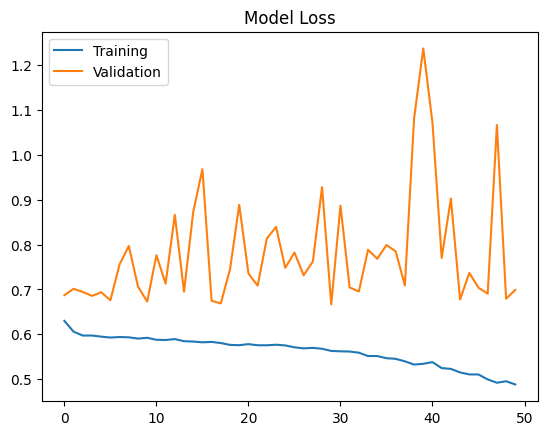

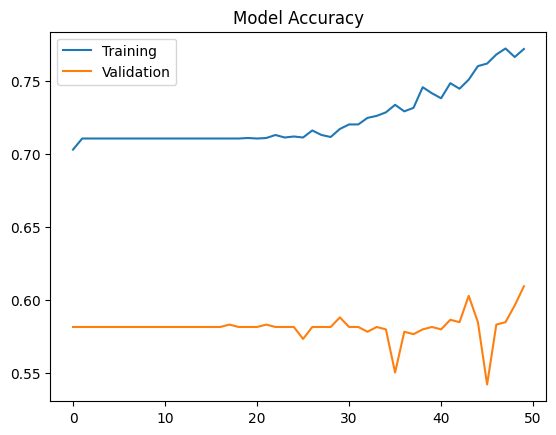

In [11]:
plt.figure()
plt.plot(history1.history['loss'], label='Training')
plt.plot(history1.history['val_loss'], label='Validation')
plt.legend(loc=0)
plt.title('Model Loss')

plt.figure()
plt.plot(history1.history['accuracy'], label='Training')
plt.plot(history1.history['val_accuracy'], label='Validation')
plt.legend(loc=0)
plt.title('Model Accuracy')

plt.show()

Model 2


In [12]:
# five convolution layer CNN - can be modified to add lstm layer
conv3 = layers.Conv2D(64, (3, 3), activation='relu', padding="same",
                      strides=(1, 1), name='Conv3')(drop1)
conv4 = layers.Conv2D(64, (3, 3), activation='relu', padding="same",
                      strides=(1, 1), name='Conv4')(conv3)
pool2 = layers.MaxPooling2D((2, 2), name='Pool2')(conv4)

batch2 = layers.BatchNormalization(name='Batch2')(pool2)

drop2 = layers.Dropout(0.2, name='Drop2')(batch2)

global_pool = layers.GlobalAveragePooling2D(name='GlobalPool')(drop2)


fc1 = layers.Dense(240, activation='relu', name='FC1')(global_pool)


output_layer = layers.Dense(1, activation='sigmoid', name='Output')(fc1)

# create the model 2
mod2 = models.Model(inputs=input_layer, outputs=output_layer)

In [13]:
mod2.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)                   │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv0 (Conv2D)                       │ (None, 64, 64, 16)          │           1,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv1 (Conv2D)                       │ (None, 64, 64, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2 (Conv2D)                       │ (None, 64, 64, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Pool1 (MaxPooling2D)                 │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Batch1 (BatchNormalization)          │ (None, 32, 32, 32)          │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Drop1 (Dropout)                      │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv3 (Conv2D)                       │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv4 (Conv2D)                       │ (None, 32, 32, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Pool2 (MaxPooling2D)                 │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Batch2 (BatchNormalization)          │ (None, 16, 16, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Drop2 (Dropout)                      │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ GlobalPool (GlobalAveragePooling2D)  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ FC1 (Dense)                          │ (None, 240)                 │          15,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output (Dense)                       │ (None, 1)                   │             241 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 86,753 (338.88 KB)

 Trainable params: 86,561 (338.13 KB)

 Non-trainable params: 192 (768.00 B)

In [14]:
mod2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [15]:
epoch_num = 50

history2 = mod2.fit(train_data, validation_data=test_data, epochs=epoch_num)

Epoch 1/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 29s 209ms/step - accuracy: 0.6924 - loss: 0.6087 - val_accuracy: 0.5829 - val_loss: 0.7804
Epoch 2/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 32s 173ms/step - accuracy: 0.7368 - loss: 0.5321 - val_accuracy: 0.5878 - val_loss: 0.7985
Epoch 3/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 14s 147ms/step - accuracy: 0.7784 - loss: 0.4917 - val_accuracy: 0.5878 - val_loss: 0.7078
Epoch 4/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 17s 182ms/step - accuracy: 0.7786 - loss: 0.4777 - val_accuracy: 0.5993 - val_loss: 0.7201
Epoch 5/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 15s 160ms/step - accuracy: 0.7843 - loss: 0.4595 - val_accuracy: 0.5632 - val_loss: 0.8187
Epoch 6/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 15s 164ms/step - accuracy: 0.7828 - loss: 0.4537 - val_accuracy: 0.5928 - val_loss: 0.7751
Epoch 7/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 15s 161ms/step - accuracy: 0.8060 - loss: 0.4379 - val_accuracy: 0.6108 - val_loss: 0.7459
Epoch 8/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 21s 167ms/step - accuracy: 0.8169 - loss: 0.4124 - val_accu

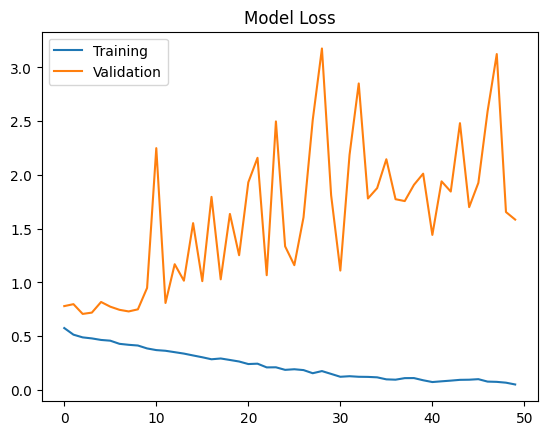

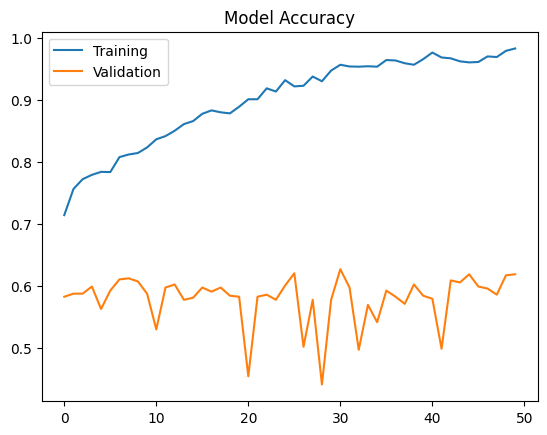

In [16]:
plt.figure()
plt.plot(history2.history['loss'], label='Training')
plt.plot(history2.history['val_loss'], label='Validation')
plt.legend(loc=0)
plt.title('Model Loss')

plt.figure()
plt.plot(history2.history['accuracy'], label='Training')
plt.plot(history2.history['val_accuracy'], label='Validation')
plt.legend(loc=0)
plt.title('Model Accuracy')

plt.show()

Transfer learning

In [17]:
base = tf.keras.applications.vgg19.VGG19(include_top=False,
                                               weights='imagenet',
                                               input_shape=(128, 128, 3),
                                               pooling='max')

tr_mod = tf.keras.models.Sequential()
tr_mod.add(base)
tr_mod.add(tf.keras.layers.Dense(240, activation='relu'))
tr_mod.add(tf.keras.layers.Dense(1, activation='sigmoid'))
base.trainable=False

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [18]:
tr_mod.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)                   │ (None, 512)                 │      20,024,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 240)                 │         123,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             241 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,147,745 (76.86 MB)

 Trainable params: 123,361 (481.88 KB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [19]:
tr_mod.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [20]:
epoch_num = 50

history3 = tr_mod.fit(
    train_data,
    validation_data=test_data,
    epochs=epoch_num
)

Epoch 1/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 31s 238ms/step - accuracy: 0.7100 - loss: 0.6131 - val_accuracy: 0.5813 - val_loss: 0.7472
Epoch 2/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 29s 182ms/step - accuracy: 0.7096 - loss: 0.5996 - val_accuracy: 0.5813 - val_loss: 0.7281
Epoch 3/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 19s 162ms/step - accuracy: 0.7082 - loss: 0.5908 - val_accuracy: 0.5681 - val_loss: 0.6910
Epoch 4/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 15s 160ms/step - accuracy: 0.7191 - loss: 0.5790 - val_accuracy: 0.5813 - val_loss: 0.7654
Epoch 5/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 15s 160ms/step - accuracy: 0.7122 - loss: 0.5830 - val_accuracy: 0.5813 - val_loss: 0.7368
Epoch 6/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 15s 166ms/step - accuracy: 0.7121 - loss: 0.5773 - val_accuracy: 0.5796 - val_loss: 0.7192
Epoch 7/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 20s 161ms/step - accuracy: 0.7144 - loss: 0.5694 - val_accuracy: 0.5747 - val_loss: 0.7046
Epoch 8/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 15s 165ms/step - accuracy: 0.7049 - loss: 0.5751 - val_accu

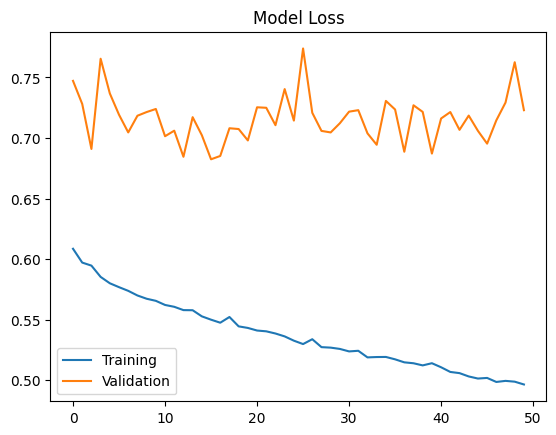

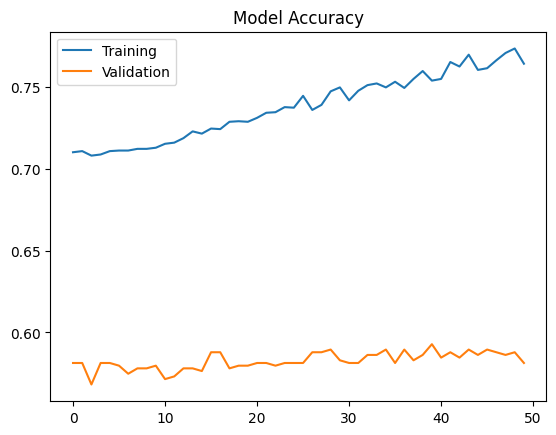

In [21]:
plt.figure()
plt.plot(history3.history['loss'], label='Training')
plt.plot(history3.history['val_loss'], label='Validation')
plt.legend(loc=0)
plt.title('Model Loss')

plt.figure()
plt.plot(history3.history['accuracy'], label='Training')
plt.plot(history3.history['val_accuracy'], label='Validation')
plt.legend(loc=0)
plt.title('Model Accuracy')

plt.show()

**Prediction**

In [22]:
# true and predicted labels
y_true = np.concatenate([y for x,y in test_data])
y_pred1 = np.argmax(mod1.predict(test_data), axis=1)
y_pred2 = np.argmax(mod2.predict(test_data), axis=1)
y_pred3 = np.argmax(tr_mod.predict(test_data), axis=1)

20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step


In [25]:
# confusion matrix
print('Confusion Matrix for model 1:')
print(confusion_matrix(y_true, y_pred1))

print('Confusion Matrix for model 2:')
print(confusion_matrix(y_true, y_pred2))

print('Confusion Matrix for model 3:')
print(confusion_matrix(y_true, y_pred3))

Confusion Matrix for model 1:
[[239 115]
 [105 150]]
Confusion Matrix for model 2:
[[245 109]
 [112 143]]
Confusion Matrix for model 3:
[[252 102]
 [102 153]]


In [26]:
# classification report
print('Classification report for model 1:')
print(classification_report(y_true, y_pred1, target_names = label_dict.keys()))

print('Classification report for model 1:')
print(classification_report(y_true, y_pred2, target_names = label_dict.keys()))

print('Classification report for model 3:')
print(classification_report(y_true, y_pred3, target_names = label_dict.keys()))

Classification report for model 1:
              precision    recall  f1-score   support

      benign       0.69      0.68      0.68       354
   malignant       0.57      0.59      0.58       255

    accuracy                           0.64       609
   macro avg       0.63      0.63      0.63       609
weighted avg       0.64      0.64      0.64       609

Classification report for model 1:
              precision    recall  f1-score   support

      benign       0.69      0.69      0.69       354
   malignant       0.57      0.56      0.56       255

    accuracy                           0.64       609
   macro avg       0.63      0.63      0.63       609
weighted avg       0.64      0.64      0.64       609

Classification report for model 3:
              precision    recall  f1-score   support

      benign       0.71      0.71      0.71       354
   malignant       0.60      0.60      0.60       255

    accuracy                           0.67       609
   macro avg       0.66

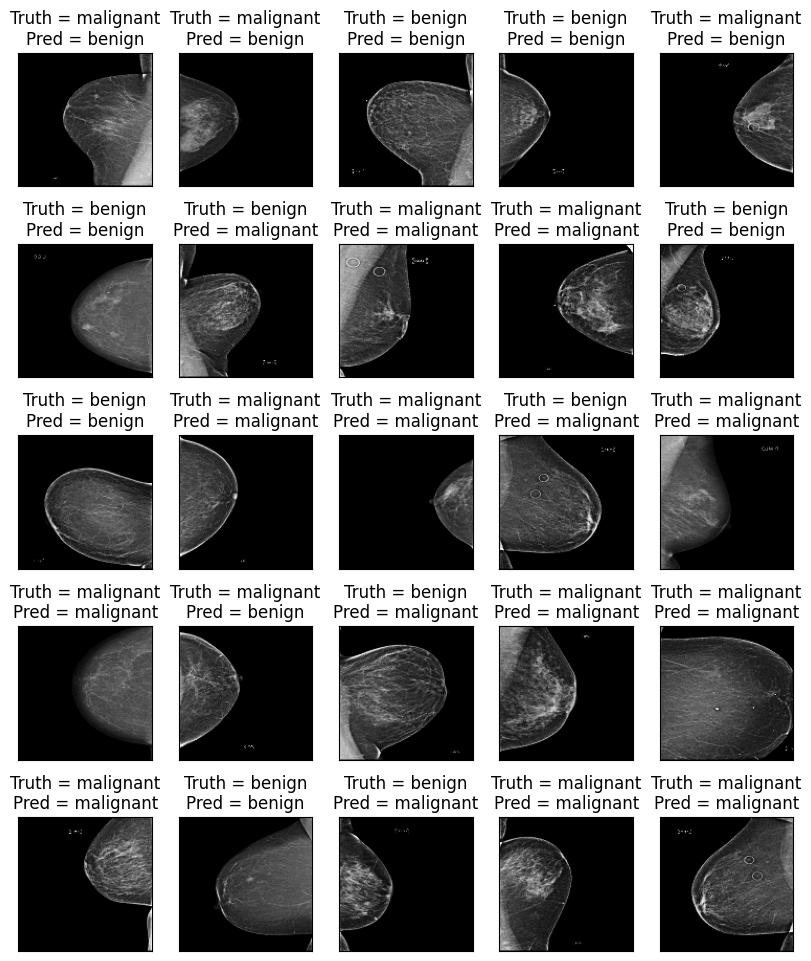

In [27]:
# display the sample predicted labels and the validation data for the transfer learning

rev_label_dict = {0 : 'malignant', 1 : 'benign'}

x_img = np.concatenate([x for x,y in test_data])

f, ax = plt.subplots(5,5, figsize=(10, 12))
ax = ax.flatten()

n = np.arange(0, 25)
indices = np.random.choice(len(n), size=25, replace=False)

for i in indices:
    ax[i].imshow(x_img[i])
    ax[i].set_title(f'Truth = {rev_label_dict[int(y_true[i])]}\nPred = {rev_label_dict[int(y_pred3[i])]}')
    ax[i].set_xticks([])
    ax[i].set_yticks([])
plt.show()